In [4]:
import sys
import os
import time
import argparse
import numpy as np
import matplotlib.pyplot as plt
import glob
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchaudio
import torchaudio.transforms as T

# Dataloader
from torch.utils.data import Dataset, DataLoader, Subset
from sklearn.model_selection import KFold
import pandas as pd

# Models
from models import CNN, MLP, LSTM
from utils import CatsAndDogsDataset, get_train_dataframe, get_hyperparameters

# Setting Seed
torch.manual_seed(0)

# Warning: to mute deprecation notifications
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="torch.nn.modules.module", lineno=1518)


In [37]:
args = {}
args['type'] = 'base'
args['train_data'] = '../Dataset/Audio Dataset/Cats and Dogs/data'
args['test_data'] = '../Dataset/Audio Dataset/Cats and Dogs/test_data'
args['folder_location'] = '../models/'
args['learning_rate'] = 1e-6
args['batch_size'] = 128
args['dropout'] = 0.4

In [40]:
# MODIFIED VERSION OF MAIN.PY FOR RUNNING IN NOTEBOOK

def train(args):
    start = time.time()
    print("Training Started.")

    # Check CUDA
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Main folder location to store artifacts
    model_folder_location = args['folder_location']

    # Create dataloader class
    train_dataframe = get_train_dataframe(args['train_data'])
    train_dataset = CatsAndDogsDataset(dataframe=train_dataframe)

    # Create model
    model = None
    if args['type'] == 'cnn':
        model = CNN(dropout=args['dropout']).to(device)
    elif args['type'] == 'base':
        model = MLP(dropout=args['dropout']).to(device)
    elif args['type'] == 'lstm':
        model = LSTM(dropout=args['dropout']).to(device)
    else:
        raise Exception(f"No such model type found: {args['type']}")

    # Loss function and optimizer
    loss_fn = nn.CrossEntropyLoss().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=args['learning_rate'])

    # Training the model
    KFOLD_SPLITS = 4
    EPOCHS = 20
    kf = KFold(n_splits=KFOLD_SPLITS, shuffle=True, random_state=10)
    all_losses = []
    # Loop over each fold and train
    for fold, (train_idx, val_idx) in enumerate(kf.split(train_dataset.df)):
        print(f"Fold: {fold}")
        # Create dataloaders for each fold, the training subset and the validation subset
        train_subset = Subset(train_dataset, train_idx)
        train_loader = DataLoader(train_subset, batch_size=args['batch_size'], shuffle=True)
        validation_subset = Subset(train_dataset, val_idx)
        validation_loader = DataLoader(validation_subset, batch_size=args['batch_size'], shuffle=True)

        # Training loop for this fold
        train_losses = []
        val_losses = []
        # For each epoch, train and validate
        for epoch in range(EPOCHS):
            cur_training_loss = 0
            model.train()
            for feature, labels in train_loader:
                feature, labels = feature.to(device), labels.to(device)
                optimizer.zero_grad()
                output = model(feature)
                loss = loss_fn(output, labels)
                loss.backward()
                optimizer.step()
                cur_training_loss += loss.item()
            epoch_training_loss = cur_training_loss / len(train_loader)
            print(f"Epoch Loss: {epoch_training_loss}")
            train_losses.append(epoch_training_loss)

            cur_validation_loss = 0
            model.eval()
            with torch.no_grad():
                for feature, labels in validation_loader:
                    feature, labels = feature.to(device), labels.to(device)
                    output = model(feature)
                    loss = loss_fn(output, labels)
                    cur_validation_loss += loss.item()
                epoch_validation_loss = cur_validation_loss / len(validation_loader)
                val_losses.append(epoch_validation_loss)
                # print(f"Epoch Validation Loss: {epoch_training_loss}")
        all_losses.append((train_losses, val_losses))

    # Save the plots
    fig, axs = plt.subplots(KFOLD_SPLITS, 1, figsize=(6, 3 * KFOLD_SPLITS))  # number of splits = number of plots
    for idx, losses in enumerate(all_losses):
        train_loss, val_loss = losses
        axs[idx].plot(np.arange(EPOCHS), train_loss, label="Training Loss")
        axs[idx].plot(np.arange(EPOCHS), val_loss, label="Validation Loss")
        axs[idx].set_title(f'Training and Validation Loss over {EPOCHS} epochs for fold {idx + 1}')
        axs[idx].set_xlabel('Epochs')
        axs[idx].set_ylabel('Loss')
        axs[idx].legend()
    plt.tight_layout()

    # Check if folders exists. if not create.
    if not os.path.exists(model_folder_location):
        os.makedirs(model_folder_location)
        print("Created folder for models, logs, plots.")

    # Model label for saving files
    label = f"{args['type']}_lr-{args['learning_rate']}_bs-{args['batch_size']}_do-{args['dropout']}"
    fig.savefig(os.path.join(model_folder_location, f'{label}_loss.png'))

    torch.save(model.state_dict(), os.path.join(model_folder_location, f'{label}.pth'))
    with open(os.path.join(model_folder_location, f'{label}_logs.txt'), 'w') as file:
        # Write each list element to the file, one element per line
        for idx in range(KFOLD_SPLITS):
            file.write(f"----Fold {idx}----\n")
            for item in all_losses[idx]:
                file.write(f"{item}\n")

    print(f"Training Concluded. Time taken: {time.time() - start}")


Training Started.
Fold: 0
Epoch Loss: 13.640183925628662
Epoch Loss: 17.077803134918213
Epoch Loss: 12.483748435974121
Epoch Loss: 13.392162799835205
Epoch Loss: 17.672441482543945
Epoch Loss: 12.48195743560791
Epoch Loss: 13.867218971252441
Epoch Loss: 11.959301471710205
Epoch Loss: 10.717511177062988
Epoch Loss: 8.373178005218506
Epoch Loss: 11.183766841888428
Epoch Loss: 12.517847537994385
Epoch Loss: 11.219569683074951
Epoch Loss: 7.899066686630249
Epoch Loss: 13.298802375793457
Epoch Loss: 9.86749005317688
Epoch Loss: 11.440572261810303
Epoch Loss: 8.024559020996094
Epoch Loss: 6.896696090698242
Epoch Loss: 5.6242101192474365
Fold: 1
Epoch Loss: 7.122500658035278
Epoch Loss: 8.858492374420166
Epoch Loss: 6.961223125457764
Epoch Loss: 6.972452640533447
Epoch Loss: 9.901774168014526
Epoch Loss: 3.428579092025757
Epoch Loss: 5.639581918716431
Epoch Loss: 8.20637559890747
Epoch Loss: 3.925841212272644
Epoch Loss: 5.584867000579834
Epoch Loss: 5.449629068374634
Epoch Loss: 5.4353420734

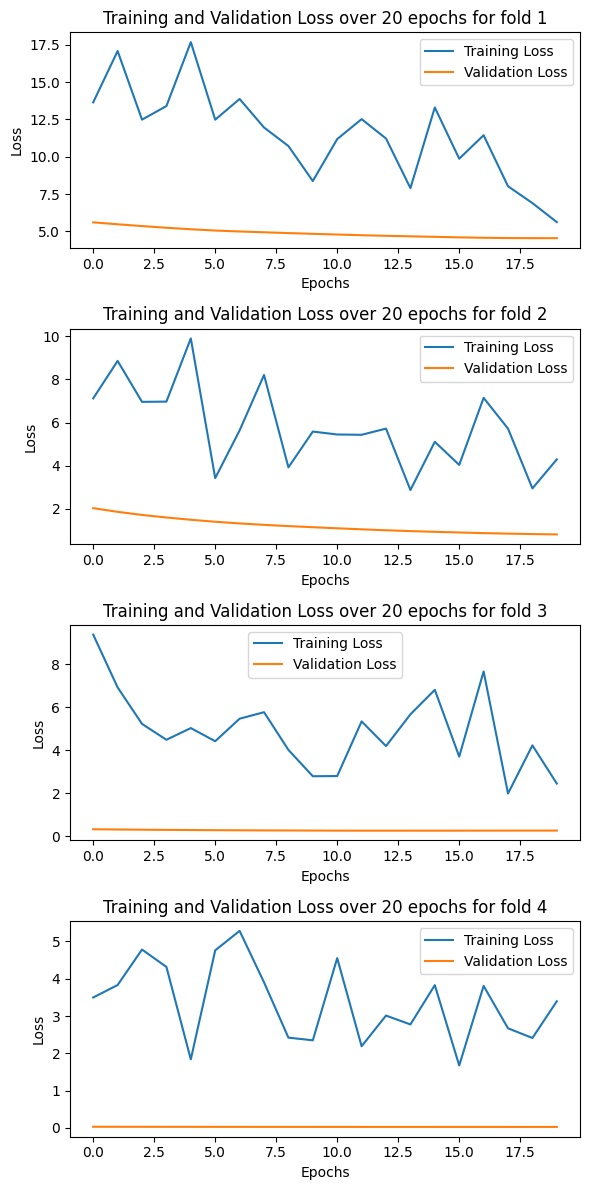

In [41]:
train(args)

### EVALUATION

In [38]:
import os
import argparse
import numpy as np
import matplotlib.pyplot as plt
import glob
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchaudio
import torchaudio.transforms as T

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

# Model
from models import CNN, MLP, LSTM
from utils import CatsAndDogsDataset, get_hyperparameters, get_test_dataframe


def test(args):
    """
    This function is used to test the model on the test data, and calculate the metrics, such as F1, F2,
    Average Precision, etc., and save them to a file.
    :param args: Command line arguments
    :return: None
    """
    model_folder_location = args['folder_location']
    label = f"{args['type']}_lr-{args['learning_rate']}_bs-{args['batch_size']}_do-{args['dropout']}"
    test_dataframe = get_test_dataframe(args['test_data'])
    try:
        print(os.path.join(model_folder_location, f'{label}.pth'))
        loaded_state_dict = torch.load(os.path.join(model_folder_location, f'{label}.pth'))
    except Exception as e:
        print(f"Error loading model state: {e}")

    # Load the test dataloader
    test_dataset = CatsAndDogsDataset(dataframe=test_dataframe)

    # Load the model
    model = None
    if args['type'] == 'cnn':
        model = CNN(dropout=args['dropout'])
        model.load_state_dict(loaded_state_dict)
    elif args['type'] == 'base':
        model = MLP(dropout=args['dropout'])
        model.load_state_dict(loaded_state_dict)
    elif args['type'] == 'lstm':
        model = LSTM(dropout=args['dropout'])
        model.load_state_dict(loaded_state_dict)
    else:
        raise Exception(f"No such model type found: {args['type']}")

    model.eval()
    with torch.no_grad():
        all_preds = []
        all_labels = []
        for data, target in test_dataset:
            data = data.unsqueeze(0)
            outputs = model(data)
            _, predicted = torch.max(outputs, 1)
            all_preds.append(predicted)
            all_labels.append(target)
            print(f"Prediction: {predicted.item()}, Actual: {target}")

    # Convert to tensors for convenience
    all_preds = torch.tensor(all_preds)
    all_labels = torch.tensor(all_labels)

    # Calculate metrics
    confusion_matrix = torch.zeros(2, 2)
    for t, p in zip(all_labels.view(-1), all_preds.view(-1)):
        confusion_matrix[t.long(), p.long()] += 1

    TP = confusion_matrix[1, 1]
    TN = confusion_matrix[0, 0]
    FP = confusion_matrix[0, 1]
    FN = confusion_matrix[1, 0]

    # Precision, Recall
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    f1 = 2 * (precision * recall) / (precision + recall)
    f2 = 5 * (precision * recall) / (4 * precision + recall)

    print("Confusion Matrix:")
    print(confusion_matrix)
    print("F1 Score:", f1.item())
    print("F2 Score:", f2.item())

    # Calculate Average Precision
    AP = average_precision_score(all_labels, all_preds)
    print("Average Precision (AP):", AP)

    # Save the metrics to a file
    with open(os.path.join(model_folder_location, f'{label}.txt'), 'w') as file:
        file.write(f"TP: {TP}\n")
        file.write(f"TN: {TN}\n")
        file.write(f"FP: {FP}\n")
        file.write(f"FN: {FN}\n")
        file.write(f"F1 Score: {f1.item()}\n")
        file.write(f"F2 Score: {f2.item()}\n")
        file.write(f"Mean Average Precision (MAP): {AP}\n")

In [42]:
test(args)

../models/base_lr-1e-06_bs-128_do-0.4.pth
Prediction: 0, Actual: 0
Prediction: 0, Actual: 0
Prediction: 0, Actual: 0
Prediction: 0, Actual: 0
Prediction: 0, Actual: 0
Prediction: 0, Actual: 0
Prediction: 0, Actual: 0
Prediction: 0, Actual: 0
Prediction: 0, Actual: 0
Prediction: 1, Actual: 0
Prediction: 1, Actual: 0
Prediction: 1, Actual: 0
Prediction: 0, Actual: 0
Prediction: 0, Actual: 0
Prediction: 0, Actual: 0
Prediction: 1, Actual: 0
Prediction: 0, Actual: 0
Prediction: 0, Actual: 0
Prediction: 0, Actual: 0
Prediction: 0, Actual: 0
Prediction: 0, Actual: 0
Prediction: 0, Actual: 0
Prediction: 0, Actual: 0
Prediction: 0, Actual: 0
Prediction: 1, Actual: 0
Prediction: 0, Actual: 0
Prediction: 0, Actual: 0
Prediction: 0, Actual: 0
Prediction: 0, Actual: 0
Prediction: 1, Actual: 0
Prediction: 1, Actual: 0
Prediction: 0, Actual: 0
Prediction: 1, Actual: 0
Prediction: 0, Actual: 0
Prediction: 0, Actual: 0
Prediction: 0, Actual: 0
Prediction: 0, Actual: 0
Prediction: 0, Actual: 0
Predicti